In [1]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
import random

tagged = dict([(p,w) for _,p,w in read_csv('../input/data/train.csv').to_records()])

len(tagged),list(tagged.items())[:5]

(9850,
 [('00022e1a.jpg', 'w_e15442c'),
  ('000466c4.jpg', 'w_1287fbc'),
  ('00087b01.jpg', 'w_da2efe0'),
  ('001296d5.jpg', 'w_19e5482'),
  ('0014cfdf.jpg', 'w_f22f3e3')])

In [2]:
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('../input/data/train/' + p): return '../input/data/train/' + p
    return p

p2size = {}
for p in tqdm_notebook(tagged):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

C:\Users\pmj44\AppData\Local\Temp/ipykernel_22124/1923699110.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm_notebook(tagged):


  0%|          | 0/9850 [00:00<?, ?it/s]

(9850,
 [('00022e1a.jpg', (699, 500)),
  ('000466c4.jpg', (1050, 700)),
  ('00087b01.jpg', (1050, 368)),
  ('001296d5.jpg', (397, 170)),
  ('0014cfdf.jpg', (700, 398))])

In [4]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('../input/files/p2h.pickle'):
    with open('../input/files/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(tagged):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())

    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h
    
    with open('p2h.pickle', 'wb') as f:
        pickle.dump(p2h, f, protocol=pickle.HIGHEST_PROTOCOL)

len(p2h), list(p2h.items())[:5]

C:\Users\pmj44\AppData\Local\Temp/ipykernel_22124/241232699.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm_notebook(tagged):


  0%|          | 0/9850 [00:00<?, ?it/s]

C:\Users\pmj44\AppData\Local\Temp/ipykernel_22124/241232699.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,h1 in enumerate(tqdm_notebook(hs)):


  0%|          | 0/9070 [00:00<?, ?it/s]

(9850,
 [('00022e1a.jpg', 'b362cc79b1a623b8'),
  ('000466c4.jpg', 'b3cccc3331cc8733'),
  ('00087b01.jpg', 'bc4ed0f2a7e168a8'),
  ('001296d5.jpg', '93742d9a2ab35b86'),
  ('0014cfdf.jpg', 'd4a1dab1c49f6352')])

In [5]:
# For each image id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
# Notice how 9850 images use only 9036 distinct image ids.
len(h2ps),list(h2ps.items())[:5]

(9036,
 [('b362cc79b1a623b8', ['00022e1a.jpg']),
  ('b3cccc3331cc8733', ['000466c4.jpg']),
  ('bc4ed0f2a7e168a8', ['00087b01.jpg']),
  ('93742d9a2ab35b86', ['001296d5.jpg']),
  ('d4a1dab1c49f6352', ['0014cfdf.jpg'])])

Images: ['0025e8c2.jpg', 'f4c81765.jpg']


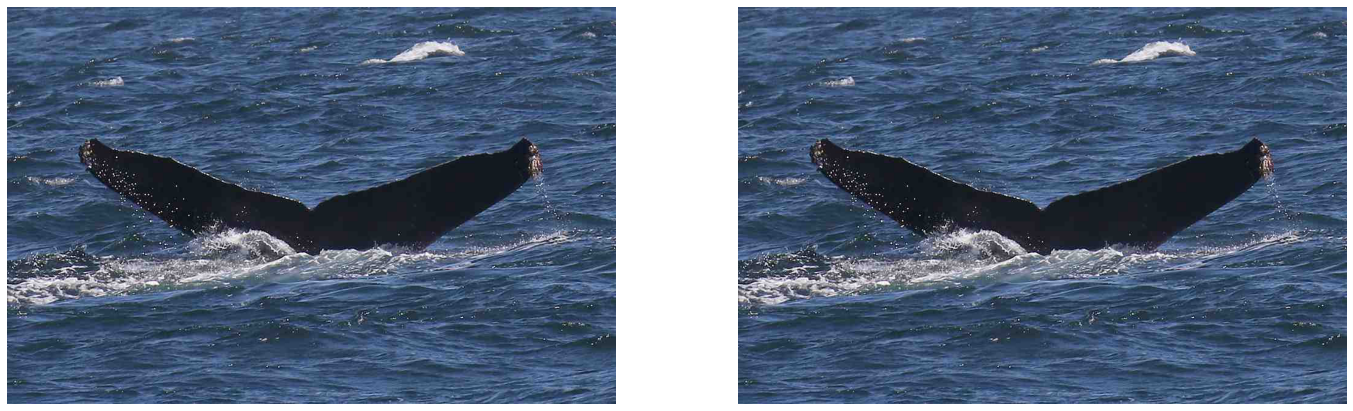

In [6]:
# Show an example of a duplicate image (from training of test set)
import matplotlib.pyplot as plt

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

for h, ps in h2ps.items():
    if len(ps) > 1:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

In [7]:
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(9036,
 [('b362cc79b1a623b8', '00022e1a.jpg'),
  ('b3cccc3331cc8733', '000466c4.jpg'),
  ('bc4ed0f2a7e168a8', '00087b01.jpg'),
  ('93742d9a2ab35b86', '001296d5.jpg'),
  ('d4a1dab1c49f6352', '0014cfdf.jpg')])

In [8]:
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

8412

In [9]:
w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous picture
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

4245

In [10]:
# Find the list of training images, keep only whales with at least three images.
data = [] # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 5:
        data += hs
random.shuffle(data)
data_set = set(data)

w2ts = {} # Associate the image ids from train to each whale id.
for w,hs in w2hs.items():
    for h in hs:
        if h in data_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(data): t2i[t] = i

len(data),len(w2ts)


(1624, 169)

In [11]:
import matplotlib.pyplot as plt


<BarContainer object of 169 artists>

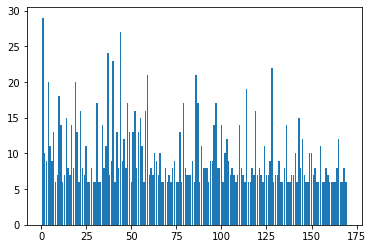

In [12]:
plt.bar(range(1,170),[len(v) for k,v in w2ts.items()])

In [13]:
train ={}
test = {}

for w,ts in w2ts.items(): 
    w_num = len(ts)
    test[w] = ts[:int(w_num/5)]
    train[w] = ts[int(w_num/5):]

In [18]:
import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

In [19]:
img_shape    = (384,384,1)

def read_for_training(p):
    """
    @param p : the name of the picture to read
    @return a numpy array with the transformed image
    """
    # Read the image, transform to black and white and comvert to numpy array
    im_gray = pil_image.open(expand_path(p)).convert('L')
    img=im_gray.resize((384,384),pil_image.BILINEAR) 
    img   = img_to_array(img)
  
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

In [20]:
a= read_for_training("0a0b2a01.jpg")

In [24]:
from cnn import ConvolutionalLayer